In [1]:
import scipy.stats as sts
import numpy as np
import pandas as pd
import itertools as itt
from tqdm import tqdm


rng = np.random.default_rng()

class MeanTest:
    threshold: float
    def __init__(self, confidence=0.95) -> None:
        threshold = sts.norm.ppf((1 - confidence) / 2)
        self.threshold = threshold
    def compute_statistic(self, A,B): 
        t_statistic, pval = sts.ttest_ind(A, B, equal_var=False)
        return t_statistic, pval    
    def test(self, A, B):
        t_statistic, _ = self.compute_statistic(A,B)
        if abs(t_statistic) < abs(self.threshold):
            return 0
        elif t_statistic > 0:
            return 1
        else:
            return -1

class mSPRT:
    threshold: float
    tau: float
    def __init__(self, confidence = 0.95, tau = 0.05) -> None:
        self.threshold = 1 - confidence
        self.tau_squared = tau ** 2
        self.p_value = 1

    def compute_statistic(self, A, B):
        x_bar = A.mean()
        y_bar = B.mean()
        n = len(A)
        Vn = x_bar * (1 - x_bar) + y_bar * (1 - y_bar) #pooled variance
        first_term = np.sqrt(Vn / (Vn + n * self.tau_squared))
        second_term = np.exp(
            (
                (n ** 2 * self.tau_squared * (y_bar - x_bar) ** 2)
            ) / 
            (
                2 * Vn * (Vn + n * self.tau_squared)
            )
        )
        return first_term * second_term

    def test(self, A, B): 
        A = np.array(A)
        B = np.array(B)       
        lr = self.compute_statistic(A, B)
        always_valid_p_value = min(self.p_value, 1/lr)
        self.p_value = always_valid_p_value
        if self.p_value > self.threshold:
            return 0
        elif A.mean() > B.mean():
            return 1
        else:
            return -1        


In [39]:
from scipy.integrate import quad
from numba import jit
import quadpy

def rv_diff(t, A_dist, B_dist): 
    f = lambda i: A_dist.pdf(i) * B_dist.pdf(i-t)
    return quadpy.quad(f, a=0, b=1)[0]

def cdf_diff(t, A_dist, B_dist):  
    f = lambda i: rv_diff(i, A_dist, B_dist)
    return quadpy.quad(f, a=-1, b=t)[0]

A = np.zeros((1000, 1))
B = np.zeros((1000, 1))
A[0:500] = 1
B[0:600] = 1

rng.shuffle(A)
rng.shuffle(B)

obs_A = (np.sum(A == 1), np.sum(A == 0))
obs_B = (np.sum(B == 1), np.sum(B == 0))


A_dist = sts.beta(a=1 + obs_A[0], b=1 + obs_A[1])
B_dist = sts.beta(a=1 + obs_B[0], b=1 + obs_B[1])

Z = A - B
mu = Z.mean()
sterror = Z.std() / np.sqrt(len(Z))

norm_approx = sts.norm(mu, sterror)

In [40]:
rv_diff(0, A_dist, B_dist)

0.0007312379558401348

In [55]:
f = lambda i: i ** (obs_A[0] - 1) * (1 - i) ** (obs_A[1] - 1) * (i - 0) ** (obs_B[0] - 1) * (1 - (i - 0)) ** (obs_B[1] - 1) 
quadpy.quad(f, a=0, b=1)[0]

i = 0.5

In [57]:
i ** (obs_A[0] - 1) * (1 - i) ** (obs_A[1] - 1)

6.10987272699921e-151

In [529]:
x,y,z = zip(*[(x,norm_approx.pdf(x), rv_diff(x, A_dist, B_dist)) for x in np.linspace(-0.3, 0.1, 100)])

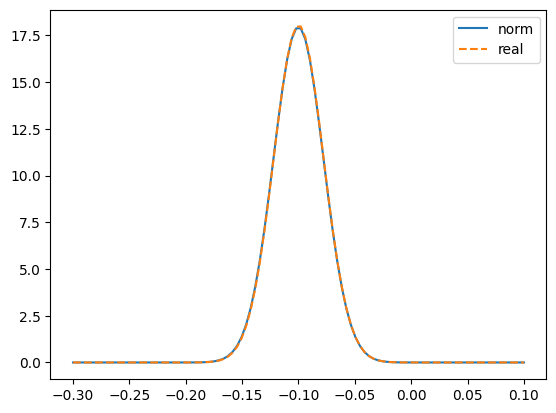

In [533]:
plt.plot(x,y, label='norm')
plt.plot(x,z, label='real', linestyle='dashed')
plt.legend()

In [ ]:
class BetaDiffNormApprox:
    confidence: float
    prior: tuple
    def __init__(self, confidence = 0.95, prior = (1, 1)) -> None:
        self.confidence = confidence
        self.prior = prior

    def compute_statistic(self, A, B):
        np.default_rng().shuffle(A)
        np.default_rng().shuffle(B)
        B_posterior = self.compute_posterior(B)

        A_dist = sts.beta(a=A_posterior[0], b=A_posterior[1])
        B_dist = sts.beta(a=B_posterior[0], b=B_posterior[1])

    

    

    def compute_posterior(self, X):
        alpha = self.prior[0] + np.sum(X)
        beta = self.prior[1] + len(X) - np.sum(X)
        return alpha, beta

    def test(self, A, B):
        pass


In [25]:
import arviz as az

class BetaDiff:
    confidence: float
    prior: tuple
    int_steps: int
    def __init__(self, confidence = 0.95, prior = (1, 1), int_steps = 1000) -> None:
        self.confidence = confidence
        self.prior = prior
        self.int_steps = int_steps

    def compute_statistic(self, A, B):
        A_posterior = self.compute_posterior(A)
        B_posterior = self.compute_posterior(B)
        A_dist = sts.beta(a=A_posterior[0], b=A_posterior[1])
        B_dist = sts.beta(a=B_posterior[0], b=B_posterior[1])

        space = np.linspace(-1,1, self.int_steps)
        emp_pdf = np.array([rv_diff(t, A_dist, B_dist) for t in space])
        emp_cdf = np.cumsum(emp_pdf)
        cut_off = (1 - self.confidence) / 2
        lower = np.min(np.where(emp_cdf >= cut_off))
        upper = np.max(np.where(emp_cdf <= self.confidence + cut_off))
        return space[lower], space[upper]
        Z = A_dist.rvs(self.int_steps) - B_dist.rvs(self.int_steps)        
        return az.hdi(Z, hdi_prob=self.confidence)

    def compute_posterior(self, X):
        alpha = self.prior[0] + np.sum(X)
        beta = self.prior[1] + len(X) - np.sum(X)
        return alpha, beta

    def test(self, A, B):
        lower, upper = self.compute_statistic(A, B)        
        if lower > 0:
            return 1
        elif upper < 0:
            return -1
        else:
            return 0


In [20]:
A = sts.bernoulli.rvs(p=0.4, size=8600, random_state=rng) 
B = sts.bernoulli.rvs(p=0.4 * (1 + 0.05), size=8600, random_state=rng)

In [21]:
t1 = MeanTest()
t1.compute_statistic(A, B)

(-3.460839054452272, 0.000539801676599106)

In [27]:
t2 = BetaDiff(int_steps=10_000)
t2.compute_statistic(A, B)

array([-0.04135761, -0.01178847])

In [26]:
t2 = BetaDiff(int_steps=10_000)
t2.compute_statistic(A, B)

array([-0.04031451, -0.01114474])

In [326]:
from statsmodels.stats.power import zt_ind_solve_power

base_rate = 0.42
detectable_lift = 0.05
sd_base = np.sqrt(base_rate * (1 - base_rate))
alpha = 0.05
power = 0.8
effect_size = base_rate * (detectable_lift) / sd_base

n = int(np.ceil(zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1)))
print(int(n))

8672


In [321]:
def simulate(variants, tests, simulations = 10_000):
    results = []
    for i in tqdm(range(simulations)):
        samples = [g() for g in variants]
        outcomes = {
            name: test().test(*samples) for name, test in tests.items()
        }        
        results.append(outcomes)
    return results

    
def simulate_peeking(variants, tests, simulations= 10_000, step_size = 500, warmup = 2000):
    results = []
    sample_sizes = []  
    complete_results = []  
    for i in tqdm(range(simulations)):
        zipped_samples = list(zip(*[g() for g in variants]))
        total_len = len(zipped_samples)
        test_objects = {name: test() for name, test in tests.items()}
        complete_results.append({
            name: test().test(*zip(*zipped_samples)) for name, test in tests.items()
        })    

        outcomes = {name: 0 for name in tests.keys()} #set initial outcomes to inconclusive
        sample_size_required = {name: total_len for name in tests.keys()} #set initial sample sizes to max
        
        current_end = warmup - step_size
        incomplete_tests = True
        while ((incomplete_tests) & (current_end <= total_len)):
            current_end += step_size
            incomplete_tests = False
            for name, outcome in outcomes.items():
                if outcome == 0:
                    seen_samples = list(zip(*zipped_samples[0:current_end]))
                    result = test_objects[name].test(*seen_samples)
                    outcomes[name] = result
                    if result != 0:
                        sample_size_required[name] = current_end
                    else:
                        incomplete_tests = True
        results.append(outcomes)
        sample_sizes.append(sample_size_required)        
    return results, sample_sizes, complete_results

In [364]:
n=8672
detectable_lift = 0
variants = [
    lambda: sts.bernoulli.rvs(p=base_rate, size=n, random_state=rng), 
    lambda: sts.bernoulli.rvs(p=base_rate * (1 + detectable_lift), size=n, random_state=rng)
]

tests = {
    "MeanTest": lambda: MeanTest(), 
    "mSPRT" : lambda: mSPRT(tau = 0.1)
}

outcomes = simulate(variants, tests, simulations=10_000)

100%|██████████| 10000/10000 [00:07<00:00, 1418.47it/s]


In [365]:
result_df = pd.DataFrame(outcomes)
np.mean(0 == result_df['mSPRT'])

0.9992

In [366]:
outcomes,sizes,full_sample_outcomes = simulate_peeking(variants, tests, simulations=1_000)

100%|██████████| 1000/1000 [00:49<00:00, 20.35it/s]


In [368]:
result_df = pd.DataFrame(outcomes)
print(np.mean((0 == result_df['mSPRT'])))
np.mean((0 == result_df['MeanTest']))

0.99


0.827